# Métricas do reprocessamento

Código feito por Igor Laltuf, ago/23

---

## Objetivo

Analisar o impacto do reprocessamento das viagens da linha 010 entre 01/06/2022 até 31/05/2023

## Etapas
Comparar valores pré e pós reprocessamento segundo as seguintes variáveis:
- A quantidade de viagens completas
- Quilometragem total de viagens completas
- Valor do subsídio a ser pago
- Explicações pontuais sobre os resultados encontrados

## Conclusão

Sobre o período entre 01/06/2022 e 31/05/2023:

1) A linha 010 não teve viagens planejadas no mês de junho de 2022.

2) A quilometragem total das viagens completas aumentou de 66.790,1 km para 81.485,2 km, um aumento de 22% após o reprocessamento.

3) A quantidade de viagens identificadas aumentou de 6.414 para 15.670 viagens. Como as viagens que antes eram circulares foram divididas em duas viagens (ida e volta), era esperado que a quantidade de viagens pelo menos dobrasse, caso nenhuma nova viagem fosse identificada.

4) O valor do subsídio antes do reprocessamento era de R$ 100.756,68 e após o reprocessamento foi de R$ 169.626,86. Vale destacar que o valor do reprocessamento foi calculado sem os descontos por km.

### Carregar bibliotecas

In [2]:
#!pip install matplotlib
import basedosdados as bd
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import folium
from datetime import timedelta, datetime
from shapely import wkt

# Paths
import os
import sys
from pathlib import Path 

current_path = Path().resolve()

paths = dict()
paths["raw"] = current_path / 'data' / 'raw'
paths["treated"] = current_path / 'data' / 'treated'

for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

# Seta o projeto a ser cobrado
bd.config.billing_project_id = "rj-smtr-dev"

# Seta as configurações a serem usadas
bd.config.project_config_path = "C:/Users/igorl/.basedosdados/"
# bd.config.project_config_path = "D:\\basedosdados\\dev"

### 1. Comparar a variação na km após o reprocessamento

In [3]:
q = f"""
SELECT
  FORMAT_DATETIME('%Y-%m', DATA) AS mes_ano,
  SUM(ROUND(distancia_planejada,2)) AS distancia_total
FROM
  `rj-smtr.projeto_subsidio_sppo.viagem_completa`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2023-05-31"
  AND servico_informado = "010"
GROUP BY
  mes_ano
"""

viagens_realizadas_010 = bd.read_sql(q, from_file=True)

viagens_realizadas_010.to_csv('data/treated/viagens_realizadas_010_jun_22-maio_23.csv', index=False)

Downloading: 100%|██████████| 11/11 [00:00<00:00, 32.54rows/s]


In [4]:
q = f"""
SELECT
  FORMAT_DATETIME('%Y-%m', DATA) AS mes_ano,
  SUM(ROUND(distancia_planejada,2)) AS distancia_total
FROM
  `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_completa`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2023-05-31"
GROUP BY
  mes_ano
"""
viagens_reprocessadas_010 = bd.read_sql(q, from_file=True)

viagens_reprocessadas_010.to_csv('data/treated/viagens_reprocessadas_010_jun_22-maio_23.csv', index=False)

Downloading: 100%|██████████| 11/11 [00:00<00:00, 30.05rows/s]


Não existem viagens planejadas para a linha 010 no mês de junho de 2022.

In [5]:
q = f"""
SELECT
  COUNT(*) AS total_linhas
FROM
  `rj-smtr.projeto_subsidio_sppo.viagem_planejada`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2022-06-30"
  AND servico = '010'
"""
viagens_planejadas_jun_2022_010 = bd.read_sql(q, from_file=True)

viagens_planejadas_jun_2022_010

Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.17rows/s]


,total_linhas
0,0


In [6]:
viagens_reprocessadas_010 = pd.read_csv('data/treated/viagens_reprocessadas_010_jun_22-maio_23.csv')
viagens_realizadas_010 = pd.read_csv('data/treated/viagens_realizadas_010_jun_22-maio_23.csv')

km_mes_ano = pd.merge(viagens_realizadas_010, viagens_reprocessadas_010, how = 'left', on='mes_ano', suffixes=['','_reprocessada'])
km_mes_ano = km_mes_ano.sort_values('mes_ano')
km_mes_ano

,mes_ano,distancia_total,distancia_total_reprocessada
6,2022-07,4235.04,4965.7
5,2022-08,6825.10,8751.9
1,2022-09,6408.30,7929.1
10,2022-10,7356.52,8211.1
7,2022-11,6658.38,7626.3
4,2022-12,6793.84,7546.7
3,2023-01,5933.70,7790.8
8,2023-02,3747.60,4716.6
2,2023-03,6412.56,8070.4
9,2023-04,5860.83,7484.4


In [7]:
distancia_total_pre_reprocessamento = km_mes_ano['distancia_total'].sum()
distancia_total_pos_reprocessamento = km_mes_ano['distancia_total_reprocessada'].sum()
print("Comparação da quilometragem das viagens completas")
print("Valor total da km pré-reprocessamento:", distancia_total_pre_reprocessamento)
print("Valor total da km pós-reprocessamento:", distancia_total_pos_reprocessamento)
print("Aumento de ",round((distancia_total_pos_reprocessamento / distancia_total_pre_reprocessamento - 1) * 100, 2),"%")

Comparação da quilometragem das viagens completas
Valor total da km pré-reprocessamento: 66790.16999999998
Valor total da km pós-reprocessamento: 81485.2
Aumento de  22.0 %


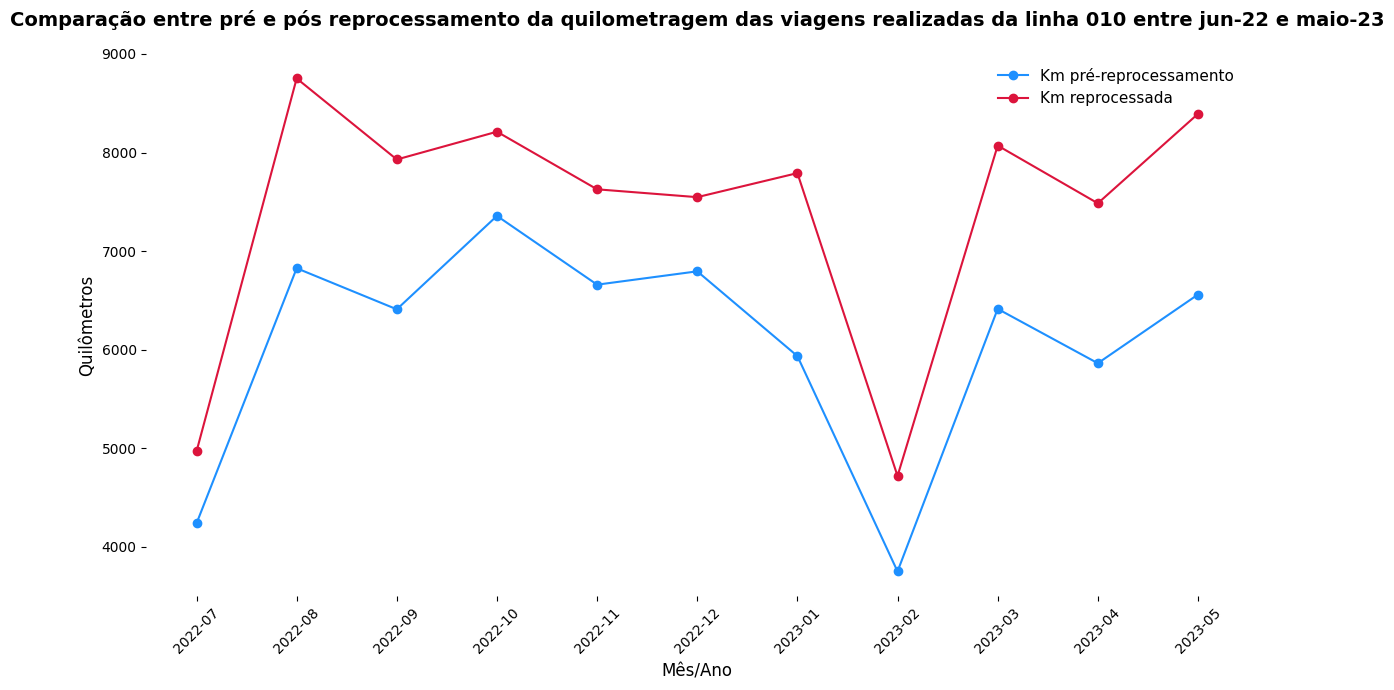

In [8]:
# tamanho do gráfico
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(km_mes_ano['mes_ano'], km_mes_ano['distancia_total'], 
         color='dodgerblue', marker='o', label='Km pré-reprocessamento')
plt.plot(km_mes_ano['mes_ano'], km_mes_ano['distancia_total_reprocessada'], 
         color='crimson', marker='o', label='Km reprocessada')

# Título, legendas e rótulos
plt.title('Comparação entre pré e pós reprocessamento da quilometragem das viagens realizadas da linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Quilômetros', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11)  

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  # Remove a grade

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 2. Comparar a variação no valor do subsídio após o reprocessamento

2.1 Valor recebido pelos consórcios antes do reprocessamento

In [9]:
q = f"""
SELECT
  CONCAT(CAST(EXTRACT(YEAR FROM DATA) AS STRING), '-', LPAD(CAST(EXTRACT(MONTH FROM DATA) AS STRING), 2, '0')) AS mes_ano,
  SUM(viagens) as viagens,
  
  SUM(valor_subsidio_pago) AS valor_subsidio
FROM
  `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
WHERE
  servico = '010'
  AND DATA BETWEEN '2022-06-01' AND '2023-05-31'
GROUP BY
  mes_ano
"""
subsidio_pago_mes = bd.read_sql(q, from_file=True)


Downloading: 100%|██████████| 11/11 [00:00<00:00, 33.74rows/s]


In [10]:
subsidio_pago_mes = subsidio_pago_mes.sort_values('mes_ano')
subsidio_pago_mes = subsidio_pago_mes[['mes_ano', 'viagens', 'valor_subsidio']]
subsidio_pago_mes

,mes_ano,viagens,valor_subsidio
9,2022-07,408,4433.15
2,2022-08,655,9864.75
1,2022-09,615,9426.57
0,2022-10,706,11781.44
4,2022-11,639,9692.20
7,2022-12,652,11609.69
8,2023-01,570,8479.80
5,2023-02,360,5175.60
10,2023-03,616,9824.87
3,2023-04,563,10526.68


2.2 Valor que deve ser pago após o reprocessamento

Com base nas viagens identificadas na tabela de viagem completa que foi reprocessada, foram verificados aqueles dias em que POD >= 80%, para então calcular o valor do subsídio de acordo com os valores por km da tabela `subsidio_data_versao_efetiva` que está no dataset `rj-smtr-dev.SMTR202212006611_reprocessamento`.

Vale destacar que esta tabela exclui as glosas de 2023 do valor do subsídio por km. Ex: considera 2.81 por km após 16 de janeiro de 2023. 

In [11]:
q = f"""
WITH
  viagem_dia AS (
  SELECT
    DATA,
    COUNT(*) AS viagens,
    SUM(distancia_planejada) AS km_apurada
  FROM
    `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_completa`
  WHERE
    DATA BETWEEN "2022-06-01"
    AND "2023-05-31"
  GROUP BY
    DATA
  ),
  viagem_planejada AS ( -- pegar a km planejada para o dia
  SELECT DISTINCT 
    DATA,
    distancia_total_planejada
  FROM
    `rj-smtr.projeto_subsidio_sppo.viagem_planejada`
  WHERE
    servico = '010'
    AND DATA BETWEEN "2022-06-01"
    AND "2023-05-31"
  ),
  tabela_pod AS (
  SELECT
    *,
    ROUND((km_apurada / distancia_total_planejada),2) AS perc_km_planejada
  FROM
    viagem_dia vd
  RIGHT JOIN
    viagem_planejada vp
  USING
    (DATA) 
  ),
  tabela_subsidio_km AS (
  SELECT
    DATA,
    valor_subsidio_por_km
  FROM
    `rj-smtr-dev.SMTR202212006611_reprocessamento.subsidio_data_versao_efetiva` )
SELECT
  DATA,
  COALESCE(viagens, 0) as viagens,
  COALESCE(km_apurada,0) as km_apurada,
  COALESCE(distancia_total_planejada,0) as distancia_total_planejada,
  COALESCE(perc_km_planejada,0) as perc_km_planejada,
  COALESCE(valor_subsidio_por_km,0) as valor_subsidio_por_km,
   CASE 
   WHEN perc_km_planejada >= 0.8 THEN valor_subsidio_por_km * km_apurada
   ELSE 0
   END as valor_subsidio
FROM
  tabela_pod
LEFT JOIN
  tabela_subsidio_km
USING
  (DATA)
"""

subsidio_a_pagar_dia = bd.read_sql(q, from_file=True)
subsidio_a_pagar_dia = subsidio_a_pagar_dia.sort_values('DATA')
subsidio_a_pagar_dia

Downloading: 100%|██████████| 335/335 [00:00<00:00, 809.17rows/s]


,DATA,viagens,km_apurada,distancia_total_planejada,perc_km_planejada,valor_subsidio_por_km,valor_subsidio
217,2022-07-01,0,0.000,290.777,0.00,1.84,0.00000
31,2022-07-02,0,0.000,181.736,0.00,1.84,0.00000
75,2022-07-03,0,0.000,145.388,0.00,1.84,0.00000
162,2022-07-04,0,0.000,290.777,0.00,1.84,0.00000
208,2022-07-05,0,0.000,290.777,0.00,1.84,0.00000
...,...,...,...,...,...,...,...
214,2023-05-27,32,166.512,166.500,1.00,2.81,467.89872
57,2023-05-28,32,166.512,145.680,1.14,2.81,467.89872
27,2023-05-29,56,291.396,312.180,0.93,2.81,818.82276
254,2023-05-30,64,333.024,312.180,1.07,2.81,935.79744


In [12]:
subsidio_a_pagar_dia['DATA'] = pd.to_datetime(subsidio_a_pagar_dia['DATA'])
subsidio_a_pagar_dia['mes_ano'] = subsidio_a_pagar_dia['DATA'].dt.strftime('%Y-%m')
subsidio_a_pagar_mes = subsidio_a_pagar_dia[['mes_ano', 'viagens', 'valor_subsidio']]
subsidio_a_pagar_mes = subsidio_a_pagar_mes.groupby('mes_ano').sum().reset_index()  
subsidio_a_pagar_mes

,mes_ano,viagens,valor_subsidio
0,2022-07,955,5419.13304
1,2022-08,1683,15350.82300
2,2022-09,1525,13548.85875
3,2022-10,1579,13167.14454
4,2022-11,1467,11438.16066
5,2022-12,1451,13090.21434
6,2023-01,1498,21699.35280
7,2023-02,906,9555.68319
8,2023-03,1552,21714.27219
9,2023-04,1440,21045.27582


O aumento do valor do subsídio não é proporcional ao aumento da quantidade de viagens, pois com o reprocessamento, cada viagem circular virou duas viagens separadas, uma de ida e outra de volta.

Isto quer dizer que o esperado era que a quantidade de viagens pelo menos dobrasse após o reprocessamento, mesmo que não fosse identificada nenhuma viagem nova.

In [13]:
# juntar as duas tabelas
tabela_subsidio_mes = pd.merge(subsidio_pago_mes, subsidio_a_pagar_mes, how='left', on='mes_ano', suffixes=['_pre','_pos'])
tabela_subsidio_mes

,mes_ano,viagens_pre,valor_subsidio_pre,viagens_pos,valor_subsidio_pos
0,2022-07,408,4433.15,955,5419.13304
1,2022-08,655,9864.75,1683,15350.82300
2,2022-09,615,9426.57,1525,13548.85875
3,2022-10,706,11781.44,1579,13167.14454
4,2022-11,639,9692.20,1467,11438.16066
5,2022-12,652,11609.69,1451,13090.21434
6,2023-01,570,8479.80,1498,21699.35280
7,2023-02,360,5175.60,906,9555.68319
8,2023-03,616,9824.87,1552,21714.27219
9,2023-04,563,10526.68,1440,21045.27582


In [14]:
tabela_subsidio_mes
total_subsidio_comparacao = tabela_subsidio_mes[['viagens_pre', 'viagens_pos','valor_subsidio_pre','valor_subsidio_pos']].sum(axis=0)
total_subsidio_comparacao

viagens_pre             6414.00000
viagens_pos            15670.00000
valor_subsidio_pre    100756.68000
valor_subsidio_pos    169626.86559
dtype: float64

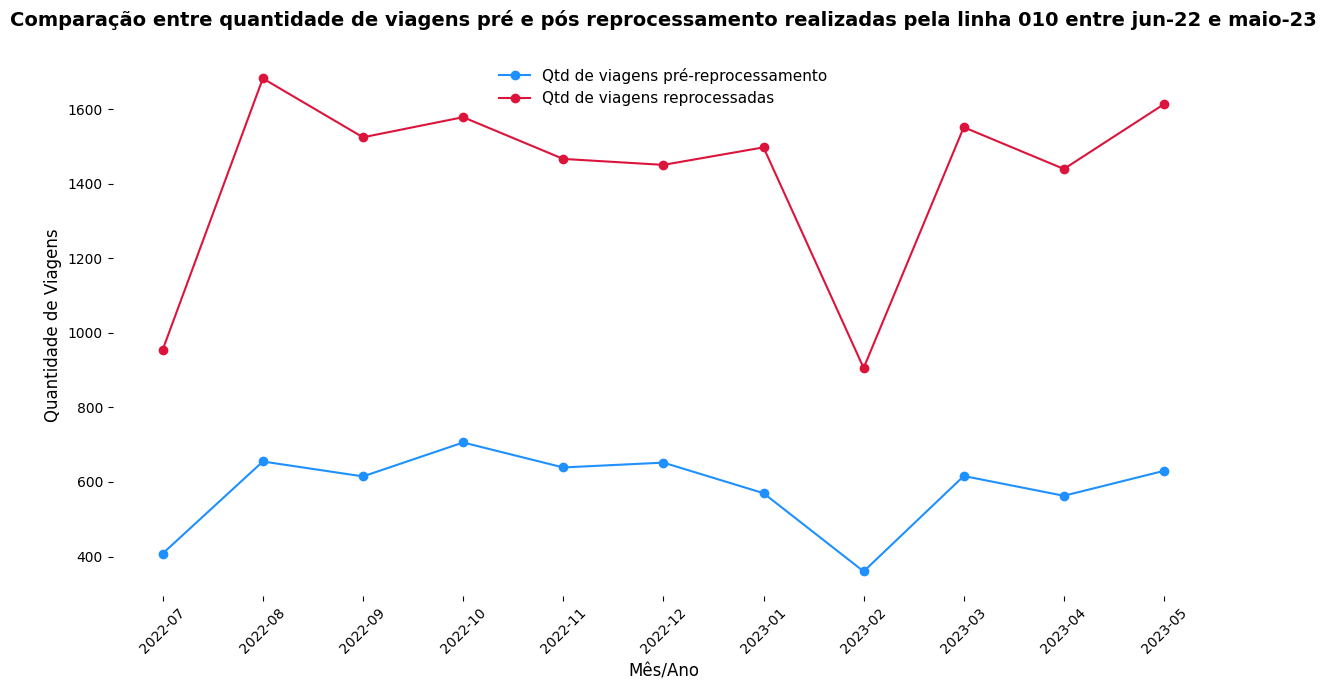

In [15]:
# tamanho do gráfico
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['viagens_pre'], 
         color='dodgerblue', marker='o', label='Qtd de viagens pré-reprocessamento')
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['viagens_pos'], 
         color='crimson', marker='o', label='Qtd de viagens reprocessadas')

# Título, legendas e rótulos
plt.title('Comparação entre quantidade de viagens pré e pós reprocessamento realizadas pela linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Quantidade de Viagens', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11) 

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  

# Exibir o gráfico
plt.tight_layout()
plt.show()

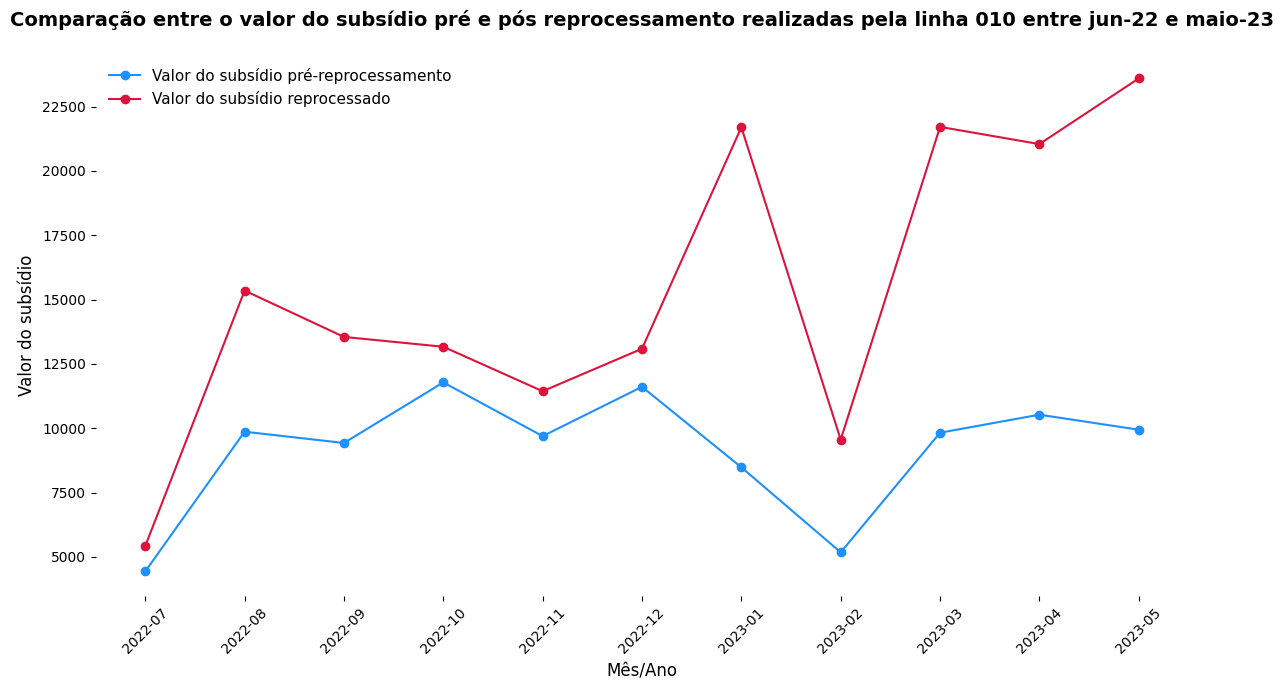

In [16]:
# tamanho do gráfico
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['valor_subsidio_pre'], 
         color='dodgerblue', marker='o', label='Valor do subsídio pré-reprocessamento')
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['valor_subsidio_pos'], 
         color='crimson', marker='o', label='Valor do subsídio reprocessado')

# Título, legendas e rótulos
plt.title('Comparação entre o valor do subsídio pré e pós reprocessamento realizadas pela linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Valor do subsídio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11) 

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 3. Análise do POD


3.1 POD pré-reprocessamento

In [17]:
# POD pré-reprocessamento
q = f"""
SELECT
  data, viagens, perc_km_planejada
FROM
  `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
WHERE
  servico = '010'
  AND DATA BETWEEN '2022-06-01' AND '2023-05-31'
"""
pod_pre_reprocessamento = bd.read_sql(q, from_file=True)

Downloading: 100%|██████████| 335/335 [00:00<00:00, 946.33rows/s]


In [18]:
# Assegurando que a coluna 'data' seja do tipo datetime
pod_pre_reprocessamento = pod_pre_reprocessamento.sort_values('data')
pod_pre_reprocessamento['data'] = pd.to_datetime(pod_pre_reprocessamento['data'])
# Criando a nova coluna 'mes_ano'
pod_pre_reprocessamento['mes_ano'] = pod_pre_reprocessamento['data'].dt.to_period('M')
pod_pre_reprocessamento['mes_ano'] = pod_pre_reprocessamento['mes_ano'].astype(str)
pod_pre_reprocessamento

,data,viagens,perc_km_planejada,mes_ano
231,2022-07-01,0,0.00,2022-07
216,2022-07-02,0,0.00,2022-07
301,2022-07-03,0,0.00,2022-07
285,2022-07-04,0,0.00,2022-07
298,2022-07-05,0,0.00,2022-07
...,...,...,...,...
30,2023-05-27,13,81.25,2023-05
103,2023-05-28,15,107.15,2023-05
19,2023-05-29,22,73.33,2023-05
83,2023-05-30,28,93.33,2023-05


In [19]:

y = "perc_km_planejada"
title = f"Distribuição do percentual de operação diária (POD) por mês - Serviço: 010"

fig = px.box(
    pod_pre_reprocessamento, 
    x="mes_ano", 
    y=y, 
    title=title,
    template="plotly_white",
    labels={
        "mes_ano": "",
        y: ""
    },
    points="all"
)

fig.update_layout(
    yaxis_range=[-10, 200],  
    yaxis_ticksuffix="%",
    width=800,
    height=600,
    showlegend=False,
)

fig.add_hline(y=80, annotation_text="min = 80%")  # Linha horizontal para indicar o mínimo de 80%

fig.show()


3.2 POD pós-reprocessamento

In [20]:
pod_pos_reprocessamento = subsidio_a_pagar_dia[["mes_ano","viagens","perc_km_planejada"]]
pod_pos_reprocessamento['perc_km_planejada'] = pod_pos_reprocessamento['perc_km_planejada'] * 100
pod_pos_reprocessamento

,mes_ano,viagens,perc_km_planejada
217,2022-07,0,0.0
31,2022-07,0,0.0
75,2022-07,0,0.0
162,2022-07,0,0.0
208,2022-07,0,0.0
...,...,...,...
214,2023-05,32,100.0
57,2023-05,32,114.0
27,2023-05,56,93.0
254,2023-05,64,107.0


In [21]:

y = "perc_km_planejada"
title = "Distribuição do percentual de operação diária (POD) por mês - Serviço: 010 <br>Versão reprocessada"

fig = px.box(
    pod_pos_reprocessamento, 
    x="mes_ano", 
    y=y, 
    title=title,
    template="plotly_white",
    labels={
        "mes_ano": "",
        y: ""
    },
    points="all"
)

fig.update_layout(
    yaxis_range=[-50, 230],  
    yaxis_ticksuffix="%",
    width=800,
    height=600,
    showlegend=False,
)

fig.add_hline(y=80, annotation_text="min = 80%")  # Linha horizontal para indicar o mínimo de 80%

fig.show()


Consolidar POD pré e pós reprocessamento em apenas um gráfico.

In [61]:
# Calcular a média e o desvio padrão de perc_km_planejada por mês para ambos os DataFrames
media_pre = pod_pre_reprocessamento.groupby('mes_ano')['perc_km_planejada'].mean()
std_pre = pod_pre_reprocessamento.groupby('mes_ano')['perc_km_planejada'].std()

media_pos = pod_pos_reprocessamento.groupby('mes_ano')['perc_km_planejada'].mean()
std_pos = pod_pos_reprocessamento.groupby('mes_ano')['perc_km_planejada'].std()


Com o reprocessamento, houve uma melhoria do valor do Percentual de Operação Diária.

In [62]:
maiores_perc_pos = subsidio_a_pagar_dia.sort_values(by='perc_km_planejada', ascending=False)
maiores_perc_pos

,DATA,viagens,km_apurada,distancia_total_planejada,perc_km_planejada,valor_subsidio_por_km,valor_subsidio,mes_ano
316,2022-10-29,61,317.112,156.292,2.03,1.62,513.72144,2022-10
299,2022-11-26,60,312.210,156.291,2.00,1.53,477.68130,2022-11
64,2022-10-22,60,312.210,156.292,2.00,1.62,505.78020,2022-10
282,2022-11-05,60,312.210,156.291,2.00,1.53,477.68130,2022-11
227,2022-11-19,60,312.210,156.291,2.00,1.53,477.68130,2022-11
...,...,...,...,...,...,...,...,...
58,2022-10-30,0,0.000,125.034,0.00,1.62,0.00000,2022-10
308,2022-12-31,0,0.000,175.828,0.00,1.78,0.00000,2022-12
246,2022-11-14,0,0.000,156.291,0.00,1.53,0.00000,2022-11
186,2023-01-01,0,0.000,145.680,0.00,3.18,0.00000,2023-01


In [75]:

# Criar o gráfico de linha
fig = go.Figure()

# Adicionar a linha com pontos e desvio padrão para pod_pre_reprocessamento
fig.add_trace(go.Scatter(x=media_pre.index, y=media_pre.values,
                    mode='lines+markers',
                    name='Antes do Reprocessamento',
                    marker=dict(color='dodgerblue'),
                    opacity=0.75,
                    error_y=dict(type='data', array=std_pre, visible=True, color='dodgerblue')  # Corrigindo a cor aqui
))

# Adicionar a linha com pontos e desvio padrão para pod_pos_reprocessamento
fig.add_trace(go.Scatter(x=media_pos.index, y=media_pos.values,
                    mode='lines+markers',
                    name='Após Reprocessamento',
                    marker=dict(color='crimson'),
                    opacity=0.75,
                    error_y=dict(type='data', array=std_pos, visible=True, color='crimson')  # Corrigindo a cor aqui
))

# Configurar layout e outros parâmetros do gráfico
fig.update_layout(
    title="Percentual de Operação Diária (POD) por mês - Serviço: 010",
    showlegend=False,
    yaxis_range=[0, 230],
    yaxis_ticksuffix="%",
    width=800,
    height=600,
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    # Adicionando anotações para o subtítulo com cores específicas
    annotations=[
        dict(
            x=-0.065,
            y=1.10,
            xref='paper',
            yref='paper',
            xanchor='left',
            text='Valor médio e desvio-padrão mensais do POD',
            showarrow=False,
            font=dict(color='black', size=14)
        ),
        dict(
            x=0.445,
            y=1.10,
            xref='paper',
            yref='paper',
            xanchor='left',
            text='antes do reprocessamento',
            showarrow=False,
            font=dict(color='dodgerblue', size=14)
        ),
        dict(
            x=0.745,
            y=1.10,
            xref='paper',
            yref='paper',
            xanchor='left',
            text='e',
            showarrow=False,
            font=dict(color='black', size=14)
        ),
        dict(
            x=0.765,
            y=1.10,
            xref='paper',
            yref='paper',
            xanchor='left',
            text='após o reprocessamento.',
            showarrow=False,
            font=dict(color='crimson', size=14)
        )
    ]
)

# Adicionar linha horizontal para indicar o mínimo de 80%
fig.add_hline(y=80, annotation_text="min = 80%")

fig.show()

### 4. Exportar planilha com dados

Exportar planilha resumo com valores a pagar antes e depois, assim como a km identificada na planilha de viagens completas.

In [24]:
km_mes_ano_soma = km_mes_ano[['distancia_total', 'distancia_total_reprocessada']].sum()
km_mes_ano_soma = km_mes_ano_soma.to_frame().T

km_mes_ano_soma = km_mes_ano_soma.rename(columns={
    'distancia_total': 'distancia_total_pre',
    'distancia_total_reprocessada': 'distancia_total_pos'
})
km_mes_ano_soma


tabela_subsidio_mes_soma = tabela_subsidio_mes[['viagens_pre', 'viagens_pos','valor_subsidio_pre', 'valor_subsidio_pos']].sum()
tabela_subsidio_mes_soma = tabela_subsidio_mes_soma.to_frame().T
tabela_subsidio_mes_soma

km_mes_ano_soma['key'] = 1
tabela_subsidio_mes_soma['key'] = 1

tabela_comparacao_exportar = km_mes_ano_soma.merge(tabela_subsidio_mes_soma, on='key', how='left').drop('key', axis=1)

tabela_comparacao_exportar
tabela_comparacao_exportar.to_excel("data/output/comparacao_pre_pos_reprocessamento_010.xlsx", index=False, engine='openpyxl')